# Exploratory analysis of structure pairs dataset
Here, we inspect the raw dataset of paired structures

In [1]:
import sys
sys.path.extend(["../code/src"])

from collections import Counter,defaultdict
from tqdm import tqdm

import numpy as np
from scipy.stats import pearsonr
import pandas as pd
from pathlib import Path

from pprint import pprint

from pdbecif.mmcif_io import CifFileReader

import matplotlib.pyplot as plt
from matplotlib_venn import venn2
%matplotlib inline
from matplotlib import rcParams
rcParams['patch.force_edgecolor'] = True
rcParams['patch.facecolor'] = 'b'
import seaborn as sns

from utils.fasta import parse_fasta, write_fasta

def isfloat(value):
  try:
    float(value)
    return True
  except ValueError:
    return False    

out_path = Path("eda_structure_pairs")
out_path.mkdir(exist_ok=True)

input_path = Path("../data/raw/pdb_pairs/")
df = pd.read_csv(input_path / "phosphorylated_residues.csv")
df["PHOSPHOSITE"] = df["UNIPROT"] + "_" + df["UNIPROT_RESIDUE_NUMBER"].astype(str)

In [2]:
unique_prots = df["UNIPROT"].unique()
unique_psites = df["PHOSPHOSITE"].unique()
print(f"How many unique proteins? {len(unique_prots)}")
print(f"How many unique phosphosites? {len(unique_psites)}")

How many unique proteins? 484
How many unique phosphosites? 812


In [3]:
ids_file = input_path / "uniprot_ids.txt"
with open(str(ids_file), 'w') as f:
    for uniprot_id in list(unique_prots):
        to_write = "".join([uniprot_id, "\n"])
        f.write(to_write)

In [4]:
pdb_ids_a = set(df["ENTRY_ID_ONE"].unique())
pdb_ids_b = set(df["ENTRY_ID_TWO"].unique())
all_pdb_ids = pdb_ids_a.union(pdb_ids_b)
all_pdb_ids = sorted([x.upper() for x in list(all_pdb_ids)])

In [5]:
pdb_ids_path = str(input_path / "pdb_ids.txt")
with open(pdb_ids_path, 'w') as f:
    for pdb_id in all_pdb_ids:
        to_write = "".join([pdb_id, '\n'])
        f.write(to_write)



# How many phosphosites per residue?

In [6]:
uniprot_ids = list(df["UNIPROT"])
phospho_aa = list(df["CHEM_COMP_TWO"])
nonphospho_aa = list(df["CHEM_COMP_ONE"])
res_idx = list(df["UNIPROT_RESIDUE_NUMBER"])

unique_sites = set(list(zip(uniprot_ids, phospho_aa, nonphospho_aa, res_idx)))
unique_phospho_aas = [aa[1] for aa in unique_sites]
unique_nonphospho_aas = [aa[2] for aa in unique_sites]
phospho_aa_counts = Counter(unique_phospho_aas)
nonphospho_aa_counts = Counter(unique_nonphospho_aas)

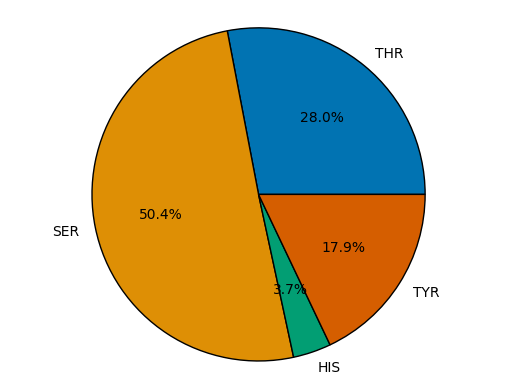

In [7]:
labels = list(nonphospho_aa_counts.keys())
values = np.array(list(nonphospho_aa_counts.values()))

aa_palette = sns.color_palette("colorblind", 4)

fig1, ax1 = plt.subplots()
ax1.pie(values,labels=labels,autopct='%1.1f%%',colors=aa_palette)
ax1.axis('equal')


plt.savefig(str(out_path / 'phosphosites_by_residue.png'), bbox_inches='tight',dpi=150)

# How many times does each Uniprot ID appear in the dataset?

Some proteins have a disproportionate number of structures. To make the plot more legible we set a limit of 1000 on the X axis.
The top 10 proteins with the greatest numbers of comparisons are as follows:

uniprot,counts
P24941, 70697
P10636, 50484
P37840, 17975
Q9NWZ3, 17128
P68431, 15144
P0CG47, 11379
O60674, 8746
O14965, 8703
P11309, 7237
Q79PF4, 6554


(0.0, 1000.0)

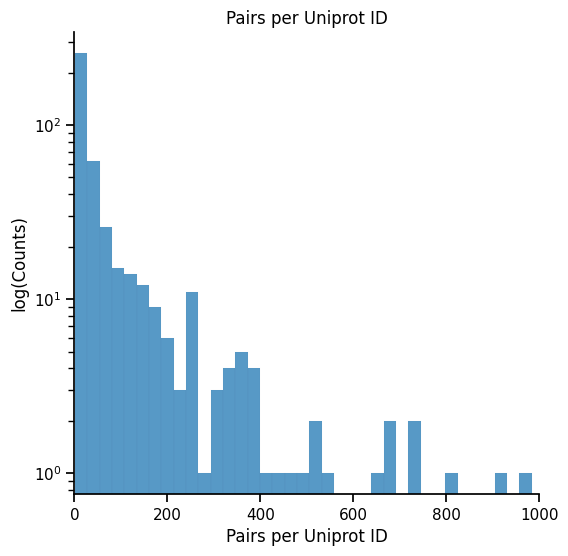

In [8]:
uniprot_id_counter = list(Counter(list(df['UNIPROT'])).values())
plt.figure(figsize=(6,6))
sns.set_context('notebook')
ax = sns.histplot(uniprot_id_counter,kde=False,color="tab:blue")
sns.despine()
ax.set_yscale('log')
ax.set_xlabel("Pairs per Uniprot ID")
ax.set_ylabel("log(Counts)")
ax.set_title("Pairs per Uniprot ID")

ax.set_xlim(0,1000)

#plt.savefig(str(out_path / "histogram_uniprot_id_appearances.png"),dpi=150, bbox_inches='tight')

# How many phosphosites per Uniprot ID?

In [9]:
uniprot_to_unique_psites = {}
for uniprot_id in unique_prots:
    subset_df = df.loc[df["UNIPROT"]==uniprot_id]
    unique_residues = subset_df["UNIPROT_RESIDUE_NUMBER"].unique()
    uniprot_to_unique_psites[uniprot_id] = len(unique_residues)
    

uniprot_to_unique_psites = sorted(uniprot_to_unique_psites.items(), key=lambda x:x[1], reverse=True)
uniprot_to_unique_psites = dict(uniprot_to_unique_psites)


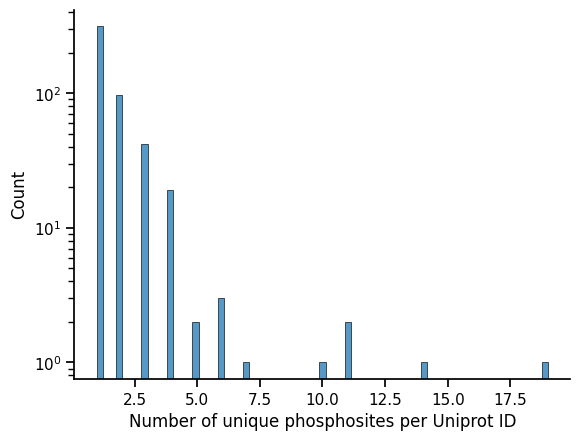

In [11]:
# The outliers are a Chlamydomonas uncharacterized protein, human microtubule-associated protein tau, human DNA-directed RNA polymerase II subunit RPB1, yeast DNA-directed RNA polymerase II subunit RPB1,
# bovine rhodopsin

ax = sns.histplot(list(uniprot_to_unique_psites.values()))
ax.set_yscale('log')

ax.set_xlabel('Number of unique phosphosites per Uniprot ID')

sns.despine()
plt.savefig(str(out_path / "histogram_uniprot_id_psites.png"),dpi=150, bbox_inches='tight')

# What species do the proteins come from?
Almost 60% human

In [12]:
uniprot_df = pd.read_csv(input_path /"uniprot"/ "uniprot_data.tsv",delimiter='\t')

How many different species? 86)


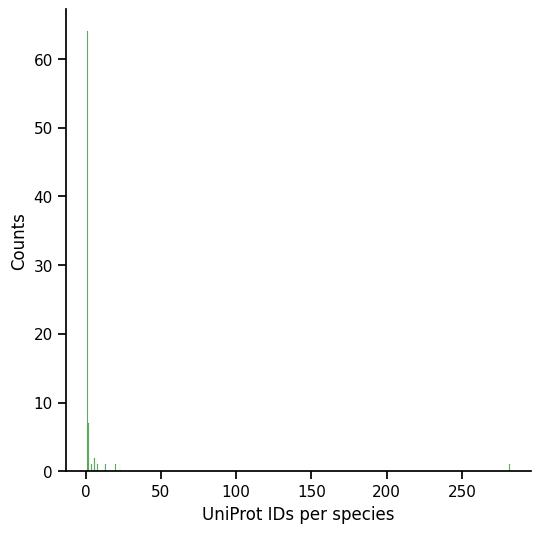

In [13]:
#pprint(Counter(uniprot_df["Organism"]).most_common())

species_counter = Counter(uniprot_df['Organism'].values.tolist())

print(f"How many different species? {len(set(species_counter.keys()))})")
sns.set_context("notebook")
plt.figure(figsize=(6,6))
ax = sns.histplot(list(species_counter.values()),kde=False,color='tab:green')
ax.set_ylabel("Counts")
ax.set_xlabel("UniProt IDs per species")
sns.despine()

#plt.savefig(str(out_path / "species_hist.png"),bbox_inches='tight',dpi=150)

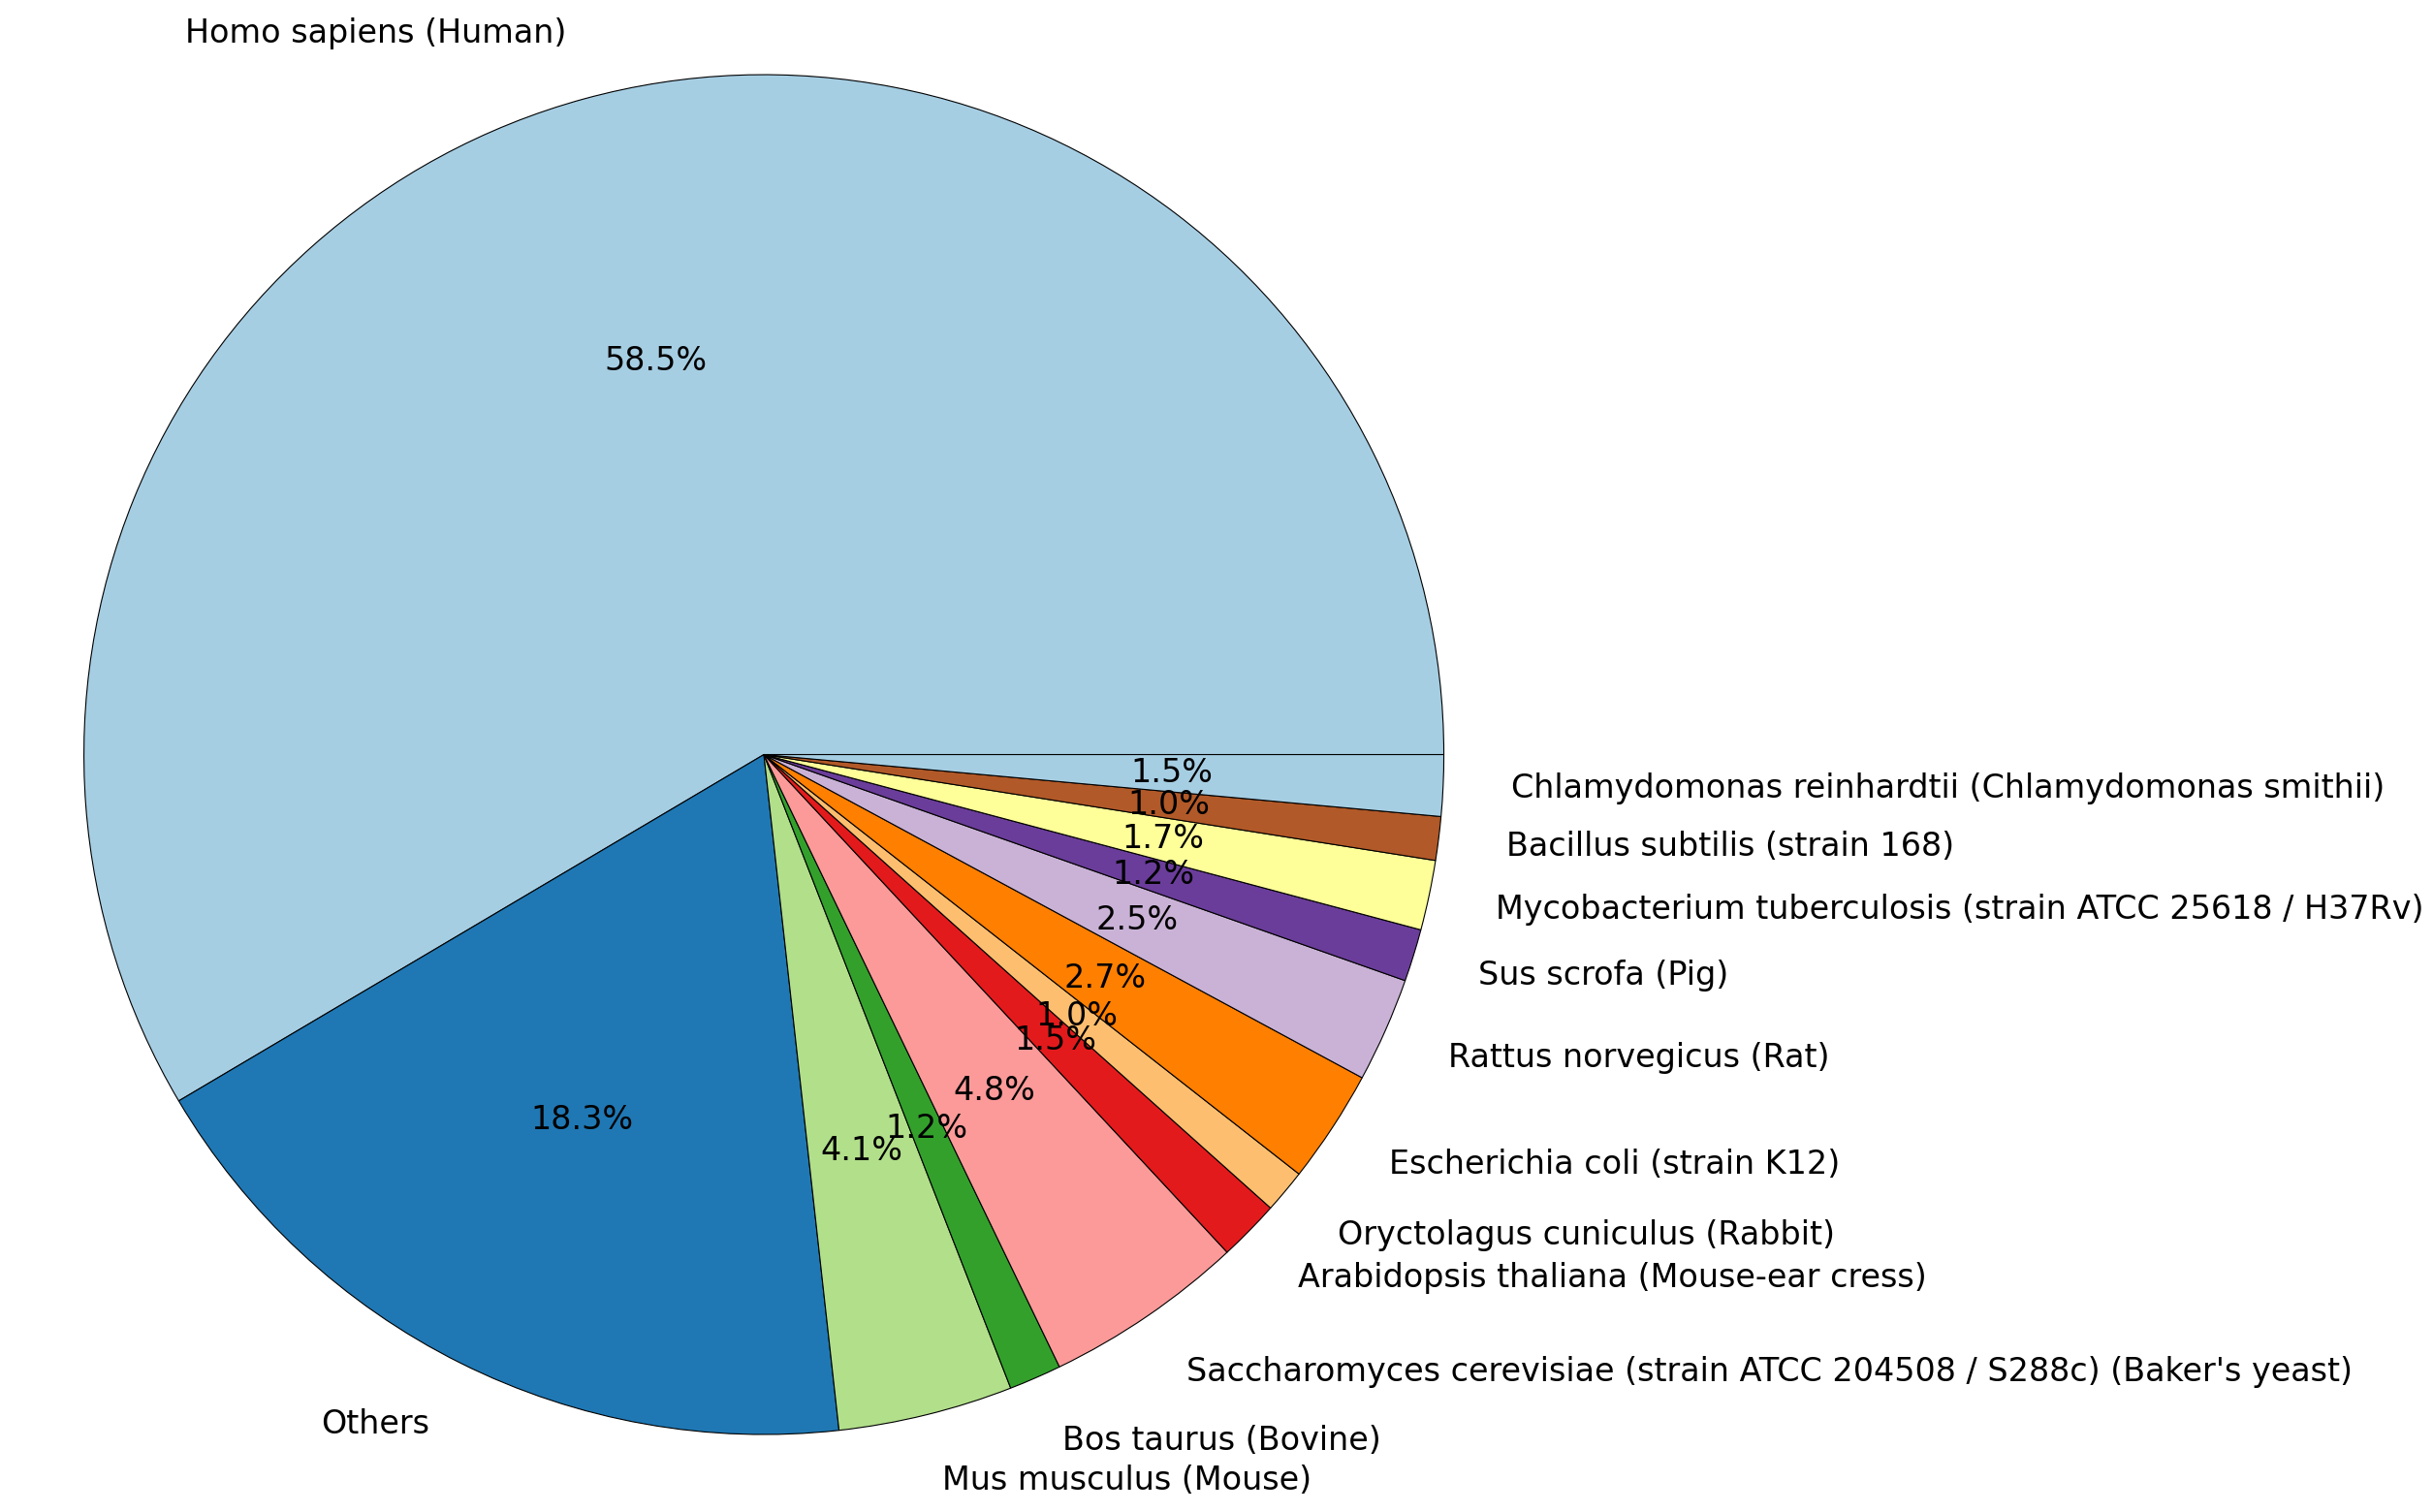

In [14]:
species_counter_shortened = defaultdict(int)
for k, v in species_counter.items():
    if v>4:
        species_counter_shortened[k] = v
    else:
        species_counter_shortened["Others"] += v
        
sns.set_context("paper")
species_labels = list(species_counter_shortened.keys())
species_values = list(species_counter_shortened.values())

fig1, ax1 = plt.subplots(figsize=(20,20))
species_palette = sns.color_palette("Paired",14)
ax1.pie(species_values,labels=species_labels,colors=species_palette, autopct='%1.1f%%',textprops={'fontsize': 24})
ax1.axis('equal')

plt.savefig(str(out_path/"species_pie.png"),bbox_inches='tight',dpi=200)

# How many phosphorylated and non-phosphorylated unique structures per UniProt ID?

In [15]:
columns = ["phosphorylated","non-phosphorylated"]
structures_per_protein_df = []

for uniprot_id in unique_prots:
    subset_df = df.loc[df["UNIPROT"]==uniprot_id]
    np_set = subset_df["ENTRY_ID_ONE"].unique()
    p_set = subset_df["ENTRY_ID_TWO"].unique()
    
    structures_per_protein_df.append([len(p_set), len(np_set)]) 
    
    #unique_phospho_structures.append(len(p_set))
    #unique_nonphospho_structures.append(len(np_set))
structures_per_protein_df = pd.DataFrame(structures_per_protein_df,columns=columns)

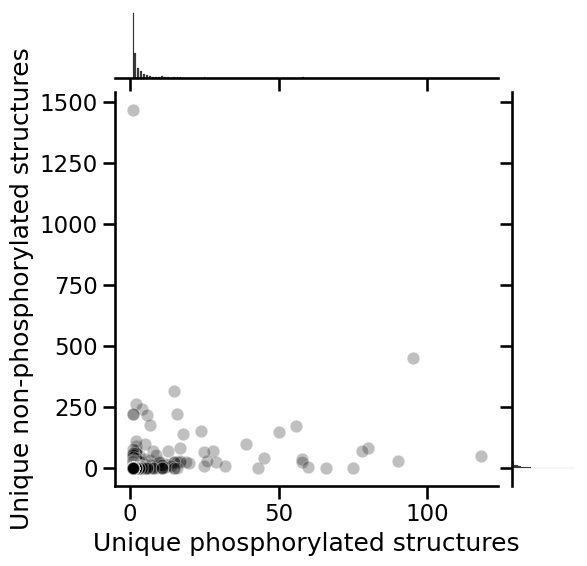

In [16]:
sns.set_context("talk")
g = sns.jointplot(data=structures_per_protein_df,x="phosphorylated",y="non-phosphorylated", color="k",alpha=.25)

plt.xlabel("Unique phosphorylated structures")
plt.ylabel("Unique non-phosphorylated structures")
plt.savefig(str(out_path/"structure_distribution_per_uniprotid.png"),bbox_inches='tight',dpi=200)

# Which methods were used to determine the structures?

In [17]:
pdb_files = list(Path("../data/raw/pdb_pairs/pdb_files/cif").glob("*.cif"))


In [18]:
reader = CifFileReader()
mmcif_tags = defaultdict(dict)
crystallography_methods = ["X-ray diffraction", "Electron Microscopy"]

for f in tqdm(pdb_files):
    structure = reader.read(f)
    pdb_id = list(structure.keys())[0]
    
    # You think this is redundant. It is not
    # Some files don't even have their own ID right
    real_pdb_id = f.parts[-1].split("_final.cif")[0]

    # Get method & quality measures
    method = structure[pdb_id]['_exptl']['method']
    # Sometimes you get something like ["X-RAY DIFFRACTION","X-RAY DIFFRACTION"]
    if isinstance(method, list):
        method = method[0]
    mmcif_tags[real_pdb_id]['method'] = method

    if method in crystallography_methods:
        
        # In cases where there are multiple resolution or R-free values,
        # take the worst case scenario
        
        if method == "X-ray diffraction":
            try: # Get resolution
                resolution = float(structure[pdb_id]['_refine']['ls_d_res_high'])
            except ValueError:
                #print(f'Error with resolution of file {pdb_id}')
                resolution = np.nan
            except TypeError:
                resolutions = structure[pdb_id]['_refine']['ls_d_res_high']
                resolutions = [float(x) for x in resolutions]
                resolution = max(resolutions)
            try: # Get R-free
                rfree = float(structure[pdb_id]['_refine']['ls_R_factor_R_free'])
            except ValueError:
                #print(f'Error with R-free of file {pdb_id}')
                rfree = np.nan
            except TypeError:
                rfrees = structure[pdb_id]['_refine']['ls_R_factor_R_free']
                rfrees = [float(x) for x in rfrees]
                rfree = max(rfrees)
    
        elif method == "Electron Microscopy":
            try: # Get resolution
                resolution = float(structure[pdb_id]['_em_3d_reconstruction']['resolution'])
            except ValueError:
                #print(f'Error with resolution of file {pdb_id}')
                resolution = np.nan
            except TypeError:
                resolutions = structure[pdb_id]['_em_3d_reconstruction']['resolution']
                resolutions = [float(x) for x in resolutions]
                resolution = max(resolutions)
        
        mmcif_tags[real_pdb_id]['resolution'] = resolution
        mmcif_tags[real_pdb_id]['rfree'] = rfree
    else:
        mmcif_tags[real_pdb_id]['resolution'] = np.nan
        mmcif_tags[real_pdb_id]['rfree'] = np.nan


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10706/10706 [11:43<00:00, 15.22it/s]


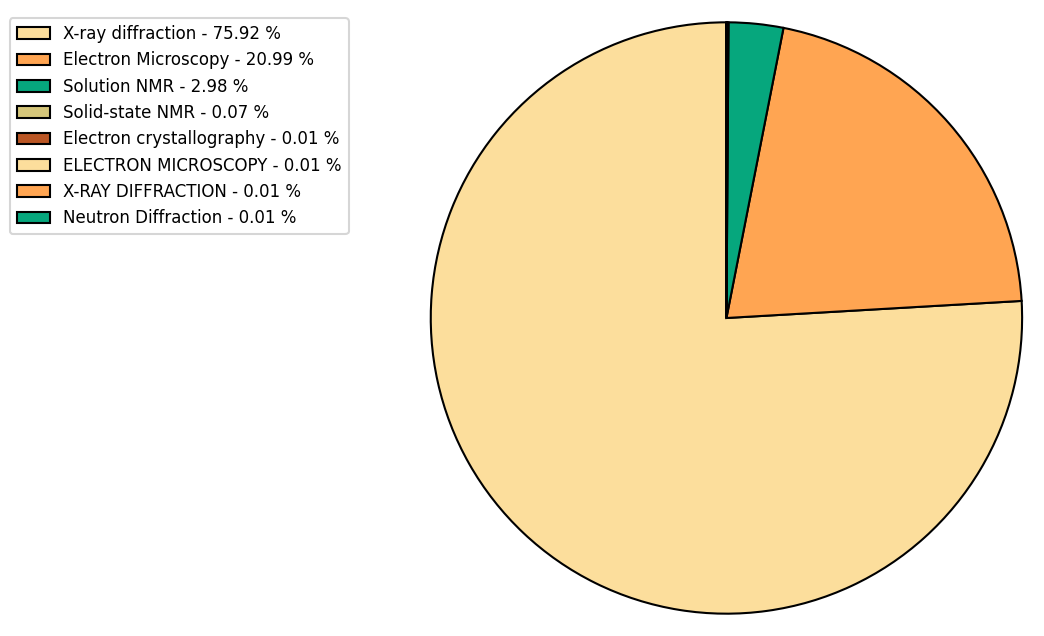

In [22]:
simple_methods = Counter([mmcif_tags[k]['method'] for k in mmcif_tags.keys()])
labels = list(simple_methods.keys())
values = np.array(list(simple_methods.values()))

# fig1, ax1 = plt.subplots()
# ax1.pie(values,labels=labels,autopct='%1.1f%%',)
# ax1.axis('equal')
plt.figure(figsize=(8,8))
sns.set_context("talk")
colors = ["#FCDE9C","#FFA552","#06A77D","#D5C67A","#BA5624"]
percents = 100*values/values.sum()
patches, texts = plt.pie(values, colors=colors, startangle=90, radius=1.2)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(labels, percents)]

plt.legend(patches, labels, loc='best', bbox_to_anchor=(-0.1, 1.),
           fontsize=12)

plt.savefig(out_path / 'structure_methods.png', bbox_inches='tight')

In [23]:
resolutions = [mmcif_tags[k]['resolution'] for k in mmcif_tags.keys()]
rfrees = [mmcif_tags[k]['rfree'] for k in mmcif_tags.keys()]

(-0.1, 4.0)

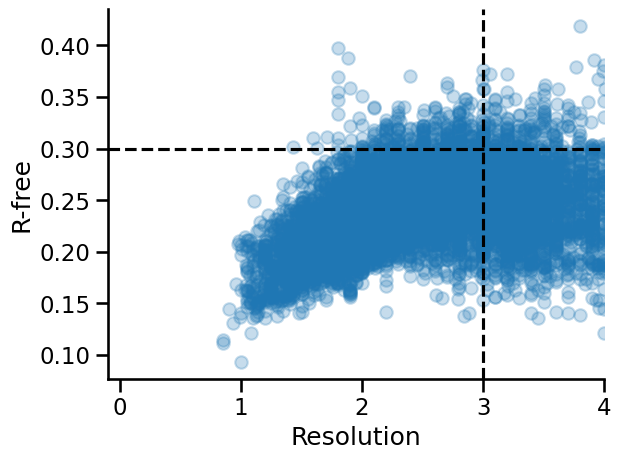

In [24]:
plt.scatter(resolutions,rfrees,alpha=0.25)
sns.despine()

plt.axvline(3,ls='--',color='black')
plt.axhline(0.3,ls='--',color='black')

plt.xlabel('Resolution')
plt.ylabel('R-free')

plt.xlim(-0.1,4)

In [25]:
cif_df = []
columns = ['pdb_id','method','resolution','rfree']
for k, subdict in mmcif_tags.items():
    pdb_id = k.split(".")[0]
    method = subdict['method']
    resolution = subdict['resolution']
    rfree = subdict['rfree']
    row = [pdb_id, method, resolution, rfree]
    cif_df.append(row)
cif_df = pd.DataFrame(cif_df,columns=columns)

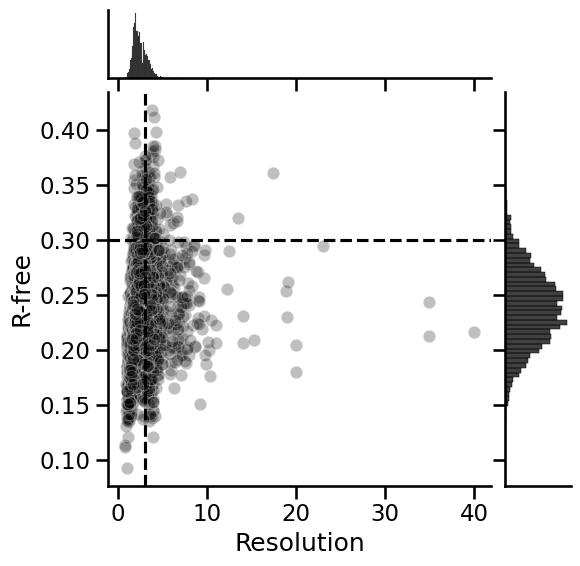

In [28]:
sns.jointplot(data=cif_df,x='resolution',y='rfree',color='black',alpha=0.25)
plt.xlabel('Resolution')
plt.ylabel('R-free')

plt.axvline(3,ls='--',color='black')
plt.axhline(0.3,ls='--',color='black')

sns.despine()
plt.savefig(out_path / "resolution_vs_rfree.png",dpi=120,bbox_inches='tight')

In [24]:
resolution_cutoff = 3
rfree_cutoff = .3

In [25]:
cif_df_nas = cif_df[cif_df['resolution'].isna() | cif_df['rfree'].isna()]
cif_df_nonas = cif_df[~cif_df['resolution'].isna() & ~cif_df['rfree'].isna()]

In [26]:
filtered_cif_df_nonas = cif_df_nonas.loc[(cif_df["resolution"]<= resolution_cutoff) & (cif_df["rfree"]<= rfree)]
print(f"Removed {len(cif_df_nonas) - len(filtered_cif_df_nonas)} structures after applying cutoffs")

Removed 2849 structures after applying cutoffs


In [27]:
nmr_methods = ["Solution NMR", "Solid-state NMR"]
cif_df_nas_nmr = cif_df_nas[cif_df_nas["method"].isin(nmr_methods)]
cif_df_nas_notnmr = cif_df_nas[~cif_df_nas["method"].isin(nmr_methods)]
# Remove rows with no resolution
cif_df_nas_notnmr = cif_df_nas_notnmr[~cif_df_nas_notnmr['resolution'].isna()]
# Remove resolution with resolution <= 3
# (nothing here has an R-free)
cif_df_nas_notnmr = cif_df_nas_notnmr.loc[cif_df_nas_notnmr['resolution']<=resolution_cutoff]
cif_df_nas = pd.concat([cif_df_nas_nmr,cif_df_nas_notnmr])

filtered_cif_df = pd.concat([filtered_cif_df_nonas, cif_df_nas])

In [28]:
valid_pdb_ids = list(filtered_cif_df["pdb_id"].unique())
valid_pdb_ids = [x.lower() for x in valid_pdb_ids]

In [29]:
filtered_df = df.loc[(df["ENTRY_ID_ONE"].isin(valid_pdb_ids)) & (df["ENTRY_ID_TWO"].isin(valid_pdb_ids))]

In [30]:
len(df["UNIPROT"].unique())

484

In [31]:
len(filtered_df["UNIPROT"].unique())

391

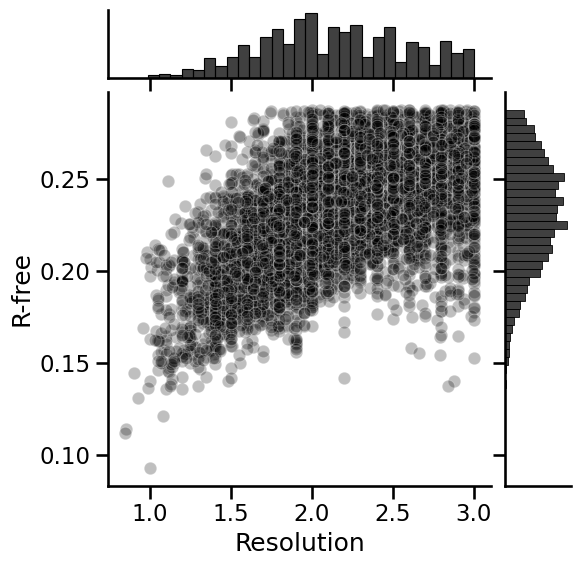

In [32]:
sns.jointplot(data=filtered_cif_df,x='resolution',y='rfree',color='black',alpha=0.25)
plt.xlabel('Resolution')
plt.ylabel('R-free')

# plt.axvline(3,ls='--',color='black')
# plt.axhline(0.3,ls='--',color='black')

sns.despine()

In [33]:
Counter(filtered_cif_df["method"])

Counter({'X-ray diffraction': 6989,
         'Electron Microscopy': 492,
         'Solution NMR': 319,
         'Solid-state NMR': 8})

In [34]:
Counter(cif_df["method"])

Counter({'X-ray diffraction': 8128,
         'Electron Microscopy': 2247,
         'Solution NMR': 319,
         'Solid-state NMR': 8,
         'Electron crystallography': 1,
         'ELECTRON MICROSCOPY': 1,
         'X-RAY DIFFRACTION': 1,
         'Neutron Diffraction': 1})

In [35]:
filtered_cif_df.to_csv(out_path / "filtered_quality_df.csv",index=False)
filtered_df.to_csv(out_path / "pdb_pairs_filtered_structure_quality.csv",index=False)